# Credit Card Fraud Detection

## Executive Summary
Recognizing fraudulent credit card transactions is important for credit card companies so that customers are not charged for items that they did not purchase. 

In this project, I used a [dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud), which has been collected during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles). The dataset contains 284,807 transactions made by european cardholders in two days (September 2013), where we have 492 fraudulent transactions. Therefore, the dataset is highly imbalanced (the positive class (frauds) account for 0.172% of all transactions). Each transaction is measured by 31 features, where 28 features (denoted by V1, V2, ..., V28) are principal components obtained by PCA; the only two features that were not transformed are 'Time' (the seconds elapsed between each transaction) and 'Amount'; the feature 'Class' is the output variable and it takes value 1 in case of fraud and 0 otherwise.

Since the data is highly imbalanced, using only the accuracy as a metric doesn't make sense. We need to use other metrics, such as **PR AUC** (Precision Recall Curve Aunder the Curve) and **F1-score**. 

I have tried several methods, including **naive Bayes** as a baseline, **logistic regression**, **random forests**, **gradient boosting trees**, and **isolation forests**. The summary of the results have been represented in the following table. As we see in the following table, Isolation Forests gave us the best result. 

|  &nbsp;   | Naive Bayes | Logistic Regression | Random Forests | Gradient Boosting | Isolation Forests |
| --- | --- | --- | --- | --- | --- |
| **Accuracy** | 99.37% | 99.91% | **99.97%** | 99.94% | 90.26% |
| **Precision** | 15.39% | 84.82% | 95.21% | 82.26% | **99.98%** |
| **Recall** | 63.98% | 51.08% | 85.48% | 82.26% | **90.26%** |
| **F1-Score** | 24.82% | 63.76% | 90.08% | 82.26% | **94.87%** |
| **PR AUC** | 31.15 % | 70.01 % | 88.87 % | 82.27 % | &nbsp; |

In [1]:
# to get rid of warnings

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import packages & modules

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

## Understanding the Data
Let us first take a look at the dataset. 

In [3]:
data = pd.read_csv('creditcard.csv')
data['Class'] = data['Class'].astype('category')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
# Normal vs. Fradulent Transactions

normal_transactions = data[data['Class'] == 0]
fraud_transactions = data[data['Class'] == 1]
print('Number of normal transactions:' + format(len(normal_transactions)) + 
     ' (' + format(round(len(normal_transactions)/len(data)*100, 2)) + '%)')
print('Number of fraudulent transactions: '+ format(len(fraud_transactions)) + 
     ' (' + format(round(len(fraud_transactions)/len(data)*100, 2)) + '%)')

Number of normal transactions:284315 (99.83%)
Number of fraudulent transactions: 492 (0.17%)


In [14]:
print('Summary of "Amount" in normal transactions:')
print(normal_transactions['Amount'].describe())

print()

print('Summary of "Amount" in fraudulent transactions:')
print(fraud_transactions['Amount'].describe())

Summary of "Amount" in normal transactions:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Summary of "Amount" in fraudulent transactions:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


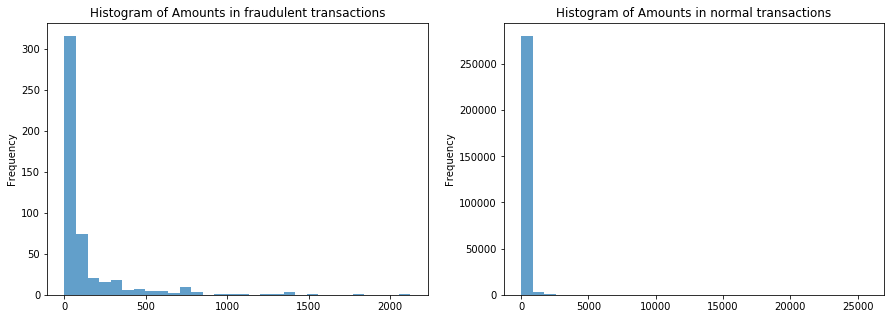

In [15]:
plt.figure(figsize=(15,5));
plt.subplot(1, 2, 1);
fraud_transactions['Amount'].plot.hist(alpha=0.7, bins=30);
plt.title('Histogram of Amounts in fraudulent transactions');

plt.subplot(1, 2, 2);
normal_transactions['Amount'].plot.hist(alpha=0.7, bins=30);
plt.title('Histogram of Amounts in normal transactions');


plt.subplots_adjust(wspace=0.2)
plt.show()

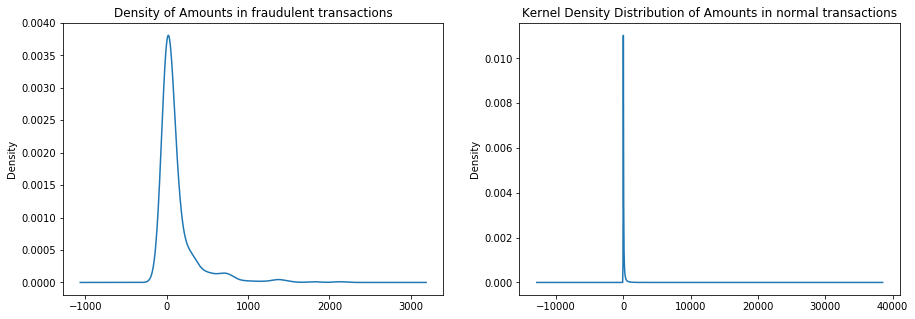

In [16]:
plt.figure(figsize=(15, 5));

plt.subplot(1, 2, 1);
fraud_transactions['Amount'].plot.kde();
plt.title('Density of Amounts in fraudulent transactions');

plt.subplot(1, 2, 2);
normal_transactions['Amount'].plot.kde();
plt.title('Kernel Density Distribution of Amounts in normal transactions');

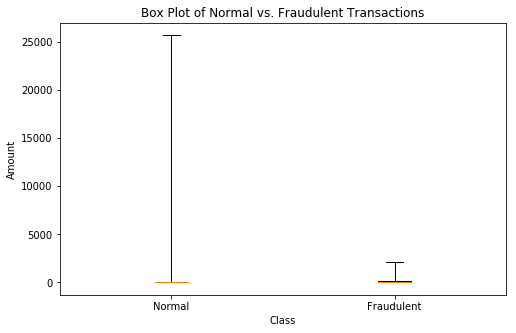

In [19]:
plt.figure(figsize=(8, 5));
plt.boxplot([normal_transactions['Amount'], fraud_transactions['Amount']], whis = 'range');
plt.axes().set_xticklabels(['Normal', 'Fraudulent']);
plt.xlabel('Class');
plt.ylabel('Amount');
plt.title('Box Plot of Normal vs. Fraudulent Transactions');

## Naive Bayes: Baseline
I use Naive Bayes as a baseline against more complicated models. 

In [20]:
# Split data into Training & Testing sets

y = data['Class']
X = data.drop(['Class'], axis=1)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

Mean f1-score (CV): 27.27 %

Accuracy: 99.37%
Precision: 15.39%
Recall: 63.98%
F1-Score: 24.82%
PR AUC: 31.15 %


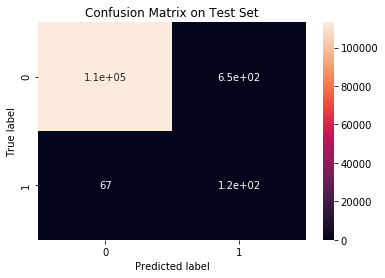

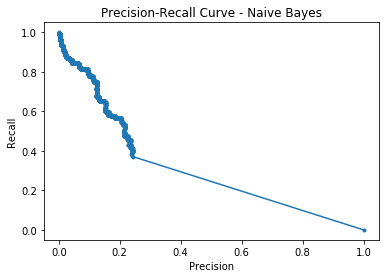

In [21]:
# Naive Bayes

naive_model = GaussianNB()
naive_cv_scores = cross_val_score(naive_model, X_train, y_train, scoring='f1', cv=10)
print('Mean f1-score (CV): {:.2f} %'.format(np.mean(naive_cv_scores)*100 ))
print()

naive_model.fit(X_train, y_train)

# predict
predicted_test = naive_model.predict(X_test)
probs_test = naive_model.predict_proba(X_test)
probs_test = probs_test[:, 1]

# confusion matrix
confusion = pd.DataFrame(confusion_matrix(y_test, predicted_test))
plt.figure();
sns.heatmap(confusion, annot=True);
plt.title('Confusion Matrix on Test Set');
plt.ylabel('True label');
plt.xlabel('Predicted label');

# accuracy
print('Accuracy: ' + format(round(accuracy_score(y_test, predicted_test)*100, 2)) + '%')

# precision
print('Precision: ' + format(round(precision_score(y_test, predicted_test)*100, 2)) + '%')

# recall
print('Recall: ' + format(round(recall_score(y_test, predicted_test)*100, 2)) + '%')

# f1-score
print('F1-Score: ' + format(round(f1_score(y_test, predicted_test)*100, 2)) + '%')

# PR Curve
precision_nb, recall_nb, threshold_nb = precision_recall_curve(y_test, probs_test)
print('PR AUC: {:.2f} %' . format(auc(recall_nb, precision_nb)*100))
plt.figure();
plt.plot(precision_nb, recall_nb, marker = '.');
plt.title('Precision-Recall Curve - Naive Bayes');
plt.xlabel('Precision');
plt.ylabel('Recall');


## Logistic Regression

In [4]:
# Split data into Training & Testing sets

y = data['Class']
X = data.drop(['Class'], axis=1)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [12]:
# Cross-Validation

scaler = MinMaxScaler()
model = LogisticRegression(max_iter = 1000, random_state=100)

pipeline = Pipeline([('transform', scaler), ('estimator', model)])
scores = cross_val_score(pipeline, X_train, y_train, cv = 10, scoring='f1')

print('F1-Scores: \n' + format(scores))
print('\nAverage F1-Score: {:.2f}' .format(np.mean(scores)*100) + '%')

F1-Scores: 
[0.64516129 0.63333333 0.6557377  0.80597015 0.6557377  0.6557377
 0.68852459 0.63333333 0.73015873 0.57627119]

Average F1-Score: 66.80%


In [15]:
# data transformation
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# train
logistic_model = model.fit(X_train_scaled, y_train)

Accuracy: 99.91%
Precision: 84.82%
Recall: 51.08%
F1-Score: 63.76%
PR AUC: 70.01 %


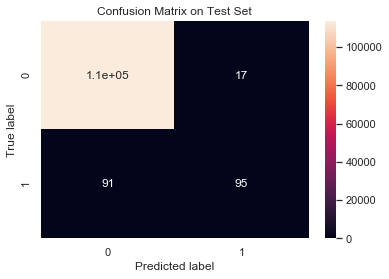

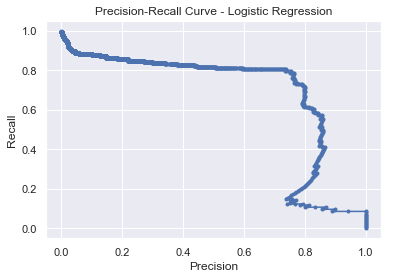

In [23]:
# Evaluate


# data transformation
X_test_scaled = scaler.transform(X_test)

# predict
predicted_test = logistic_model.predict(X_test_scaled)
probs_test = logistic_model.predict_proba(X_test_scaled)
probs_test = probs_test[:, 1]

# confusion matrix
confusion = pd.DataFrame(confusion_matrix(y_test, predicted_test))
plt.figure();
sns.heatmap(confusion, annot=True);
plt.title('Confusion Matrix on Test Set');
plt.ylabel('True label');
plt.xlabel('Predicted label');

# accuracy
print('Accuracy: ' + format(round(accuracy_score(y_test, predicted_test)*100, 2)) + '%')

# precision
print('Precision: ' + format(round(precision_score(y_test, predicted_test)*100, 2)) + '%')

# recall
print('Recall: ' + format(round(recall_score(y_test, predicted_test)*100, 2)) + '%')

# f1-score
print('F1-Score: ' + format(round(f1_score(y_test, predicted_test)*100, 2)) + '%')

# PR Curve
precision_log, recall_log, threshold_log = precision_recall_curve(y_test, probs_test)
print('PR AUC: {:.2f} %' . format(auc(recall_log, precision_log)*100))
plt.figure();
plt.plot(precision_log, recall_log, marker = '.');
plt.title('Precision-Recall Curve - Logistic Regression');
plt.xlabel('Precision');
plt.ylabel('Recall');


## Random Forest

In [36]:
# split the data

y = data['Class']
X = data.drop(['Class'], axis=1)

# Splitting data into training, validation, testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [33]:
# random forest model initialization
rf_model = RandomForestClassifier(random_state=100)

# scaler initialization
scaler = MinMaxScaler()

# pipline to fit into the Random Search CV
pipeline = Pipeline([('transformer', scaler), ('estimator', rf_model)])

# parameters to optimize through CV
max_depth = [x for x in np.arange(10, 110, 10)]
max_depth.append(None)
params = {'estimator__n_estimators': np.arange(30, 100, 10), 'estimator__max_depth': max_depth}

# Radnomized Search Cross-Validation to tune hyper parameters
searchcv = RandomizedSearchCV(pipeline, params, scoring='f1', random_state=100).fit(X_train, y_train)
best_estimator_rf = searchcv.best_estimator_
best_params_rf = searchcv.best_params_

print('Best hyper parameters: ' + format(best_params_rf))

Best hyper parameters: {'estimator__n_estimators': 80, 'estimator__max_depth': 60}


In [34]:
# train

X_train_scaled = scaler.fit_transform(X_train)
rf_model = RandomForestClassifier(n_estimators=80, max_depth=60, random_state=100).fit(X_train_scaled, y_train)

In [35]:
# data transformation test
X_test_scaled = scaler.transform(X_test)

# prediction
predicted_test_rf = rf_model.predict(X_test_scaled)
probs_test_rf = rf_model.predict_proba(X_test_scaled)
probs_test_rf = probs_test_rf[:, 1]

Accuracy: 99.97%
Precision: 95.21%
Recall: 85.48%
F1-Score: 90.08%
PR AUC: 88.87 %


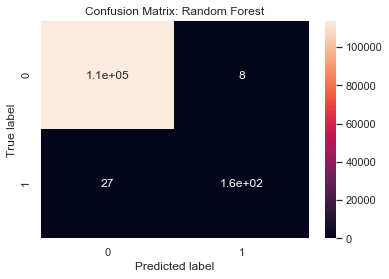

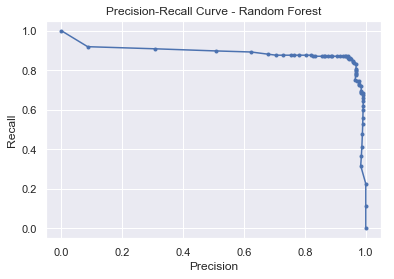

In [36]:
# confusion matrix
confusion = pd.DataFrame(confusion_matrix(y_test, predicted_test_rf))
plt.figure();
sns.heatmap(confusion, annot=True);
plt.title('Confusion Matrix: Random Forest');
plt.ylabel('True label');
plt.xlabel('Predicted label');

# accuracy
print('Accuracy: ' + format(round(accuracy_score(y_test, predicted_test_rf)*100, 2)) + '%')

# precision
print('Precision: ' + format(round(precision_score(y_test, predicted_test_rf)*100, 2)) + '%')

# recall
print('Recall: ' + format(round(recall_score(y_test, predicted_test_rf)*100, 2)) + '%')

# f1-score
print('F1-Score: ' + format(round(f1_score(y_test, predicted_test_rf)*100, 2)) + '%')

# PR Curve
precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_test, probs_test_rf)
print('PR AUC: {:.2f} %' . format(auc(recall_rf, precision_rf)*100))
plt.figure();
plt.plot(precision_rf, recall_rf, marker = '.');
plt.title('Precision-Recall Curve - Random Forest');
plt.xlabel('Precision');
plt.ylabel('Recall');


## Gradient Boosting Trees

In [49]:
y = data['Class']
X = data.drop(['Class'], axis=1)

# Splitting data into training, validation, testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [38]:
# gradient boosting model initialization
gb_model = GradientBoostingClassifier()

# scaler initialization
scaler = MinMaxScaler()

# pipline to fit into the Random Search CV
pipeline = Pipeline([('transformer', scaler), ('estimator', gb_model)])

# parameters to optimize through CV
max_depth = [x for x in np.arange(10, 110, 11)]
max_depth.append(None)
params = {'estimator__learning_rate': np.linspace(0.08, 0.3, 12), 
          'estimator__n_estimators': np.arange(40, 150, 10),
         'estimator__subsample': [0.8, 0.9, 1.0],
         'estimator__max_depth': max_depth}

# Radnomized Search Cross-Validation to tune hyper parameters
searchcv = RandomizedSearchCV(pipeline, params, random_state=100, scoring='f1')
searchcv.fit(X_train, y_train)
best_estimator_gb = searchcv.best_estimator_
best_params_gb = searchcv.best_params_

print('Best hyper parameters: ' + format(best_params_gb))

Best hyper parameters: {'estimator__subsample': 1.0, 'estimator__n_estimators': 100, 'estimator__max_depth': None, 'estimator__learning_rate': 0.1}


In [39]:
# train

X_train_scaled = scaler.fit_transform(X_train)
gb_model = GradientBoostingClassifier(subsample= 1.0, n_estimators= 100, 
                                      max_depth= None, learning_rate= 0.1).fit(X_train_scaled, y_train)

In [40]:
# data transformation test
X_test_scaled = scaler.transform(X_test)

# prediction
predicted_test_gb = gb_model.predict(X_test_scaled)
probs_test_gb = gb_model.predict_proba(X_test_scaled)
probs_test_gb = probs_test_gb[:, 1]

Accuracy: 99.94%
Precision: 82.26%
Recall: 82.26%
F1-Score: 82.26%
PR AUC: 82.27 %


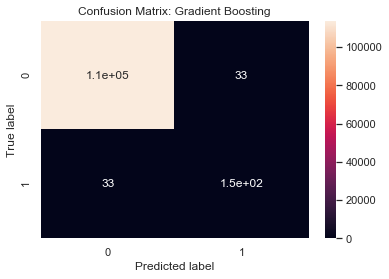

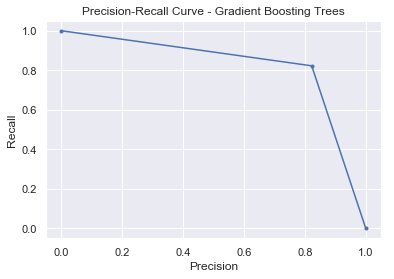

In [41]:
# confusion matrix
confusion = pd.DataFrame(confusion_matrix(y_test, predicted_test_gb))
plt.figure();
sns.heatmap(confusion, annot=True);
plt.title('Confusion Matrix: Gradient Boosting');
plt.ylabel('True label');
plt.xlabel('Predicted label');

# accuracy
print('Accuracy: ' + format(round(accuracy_score(y_test, predicted_test_gb)*100, 2)) + '%')

# precision
print('Precision: ' + format(round(precision_score(y_test, predicted_test_gb)*100, 2)) + '%')

# recall
print('Recall: ' + format(round(recall_score(y_test, predicted_test_gb)*100, 2)) + '%')

# f1-score
print('F1-Score: ' + format(round(f1_score(y_test, predicted_test_gb)*100, 2)) + '%')

# PR Curve
precision_gb, recall_gb, _ = precision_recall_curve(y_test, probs_test_gb)
print('PR AUC: {:.2f} %' . format(auc(recall_gb, precision_gb)*100))
plt.figure();
plt.plot(precision_gb, recall_gb, marker = '.');
plt.title('Precision-Recall Curve - Gradient Boosting Trees');
plt.xlabel('Precision');
plt.ylabel('Recall');

## Isolation Forest
Although the dataset is labeled, we can see this problem as an unsupervised outlier detection one, and use the labels to evaluate the accuracy of the model.

In [50]:
# Isolation Forests (Good Result)

data_iso = deepcopy(data)
data_iso.loc[data_iso['Class']==1, 'Class'] = -1
data_iso.loc[data_iso['Class']==0, 'Class'] = 1

y = data_iso['Class']
X = data_iso.drop(['Class'], axis=1)

# Splitting data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# train
iForests1 = IsolationForest(n_estimators=100, max_samples=250, random_state =100, behaviour = 'new')
iForests1.fit(X_train)

# predict
predicted_valid = iForests1.predict(X_valid)
predicted_test = iForests1.predict(X_test)


# accuracy
print('"Accuracy" on the Validation set: ' + format(round(accuracy_score(y_valid, predicted_valid)*100, 2)) + '%')
print('"Accuracy" on the Testing set: ' + format(round(accuracy_score(y_test, predicted_test)*100, 2)) + '%')

# precision
print('\n"Precision" on the Validation set: ' + format(round(precision_score(y_valid, predicted_valid)*100, 2)) + '%')
print('"Precision" on the Testing set: ' + format(round(precision_score(y_test, predicted_test)*100, 2)) + '%')

# recall
print('\n"Recall" on the Validation set: ' + format(round(recall_score(y_valid, predicted_valid)*100, 2)) + '%')
print('"Recall" on the Testing set: ' + format(round(recall_score(y_test, predicted_test)*100, 2)) + '%')

# f1-score
print('\n"F1-Score" on the Validation set: ' + format(round(f1_score(y_valid, predicted_valid)*100, 2)) + '%')
print('"F1-Score" on the Testing set: ' + format(round(f1_score(y_test, predicted_test)*100, 2)) + '%')

"Accuracy" on the Validation set: 90.31%
"Accuracy" on the Testing set: 90.26%

"Precision" on the Validation set: 99.97%
"Precision" on the Testing set: 99.98%

"Recall" on the Validation set: 90.32%
"Recall" on the Testing set: 90.26%

"F1-Score" on the Validation set: 94.9%
"F1-Score" on the Testing set: 94.87%


In [56]:
# Tune the hyper parameters (RandomSearchCV) - Isolation Forests

data_iso = deepcopy(data)
data_iso.loc[data_iso['Class']==1, 'Class'] = -1
data_iso.loc[data_iso['Class']==0, 'Class'] = 1

y = data_iso['Class']
X = data_iso.drop(['Class'], axis=1)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

iForests2 = IsolationForest(random_state =100, behaviour = 'new')
params = {'n_estimators':np.arange(100, 150 , 10), 'max_samples':np.arange(250, 300, 20)}

# find the best estimator
randsearch = RandomizedSearchCV(iForests2, params, scoring = 'f1', random_state=100)
search = randsearch.fit(X_train, y_train)
best_estimator_iForest = search.best_estimator_
best_params = search.best_params_
best_score = search.best_score_

print('The best hyper parameters: ' + format(best_params))
print('The best f1-score: ' + format(round(best_score*100, 2)) + '%')

# test
predicted_test = best_estimator_iForest.predict(X_test)

# accuracy
print('\nAccuracy: ' + format(round(accuracy_score(y_test, predicted_test)*100, 2)) + '%')

# precision
print('Precision: ' + format(round(precision_score(y_test, predicted_test)*100, 2)) + '%')

# recall
print('Recall: ' + format(round(recall_score(y_test, predicted_test)*100, 2)) + '%')

# f1-score
print('F1-Score: ' + format(round(f1_score(y_test, predicted_test)*100, 2)) + '%')

The best hyper parameters: {'n_estimators': 140, 'max_samples': 270}
The best f1-score: 94.84%

Accuracy: 90.1%
Precision: 99.98%
Recall: 90.11%
F1-Score: 94.79%
